In [31]:
from pathlib import Path
PROJECT_ROOT = Path.cwd().parents[1]
import sys
sys.path.append(str(PROJECT_ROOT))
# from bahamas_lig.utils import *
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.gridspec as gridspec
import itertools
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from osgeo import gdal
from gdalconst import GA_ReadOnly
import ogr
import pandas as pd
from PIL import Image
import scipy
from scipy.stats import gaussian_kde

PROJECT_ROOT = Path().resolve().parents[1]
data_dir =PROJECT_ROOT/'data/'
model_dir =PROJECT_ROOT/'model_outputs/'

def get_field_data():
    """
    Loads and prepares the field data from master_elevations.csv

    Parameters
    ----------
    none

    Returns
    -------
    field_island_data: RSL peak sea level elevation and location data for Bahamas field data
    fu: uncertainty (2-sigma) of the elevations in field_island_data
    island_data_combo: RSL peak sea level elevation and location data for Bahamas field data as well as satellite derived estimates of peak sea level
    cu: uncertainty (2-sigma) of the elevations in island_data_combo
    """
    island_data = pd.read_csv(data_dir / "processed/master_elevations.csv")
    added_field_u = 0.15  # somewhat arbitrary 'uncertainty' -- ie, how close do we think field obs is to max sea level?

    island_data_combo = island_data.values[:, [0, 1, 3, 4]][
        [0, 3, 5, 9, 14, 15, 16, 17, 18, 19, 20], :
    ]  # indices for specific islands
    cu = island_data.values[:, [2]][
        [0, 3, 5, 9, 14, 15, 16, 17, 18, 19, 20], :
    ]  # indices for specific islands

    field_island_data = island_data[island_data["Type"] == "Field"].values[
        :, [0, 1, 3, 4]
    ]
    fu = island_data[island_data["Type"] == "Field"].values[:, [2]] + added_field_u

    cu[-1 * len(fu) :] += added_field_u

    return field_island_data, fu, island_data_combo, cu

In [3]:
## Styling
sns.set_palette("viridis", n_colors=6)
sns.set_style(
    "ticks",
    {
        "axes.edgecolor": ".3",
        "xtick.color": ".3",
        "ytick.color": ".3",
        "text.color": ".3",
        "axes.facecolor": "(.98,.98,.98)",
        "axes.grid": True,
        "grid.color": ".9",
        "grid.linestyle": u"-.",
    },
)
sns.set_context("talk")

In [4]:
vector_layer = "Island_shapes.shp"
raster_layer = "tDEMx_lo_filtered_corr.tif"
target_layer = "masks.tif"
map_layer = "labeled_georaster.tif"

In [8]:
map_ds = gdal.Open(
    str(data_dir) + "/processed/" + map_layer, gdal.GA_ReadOnly
)  ##2 == 5e flat, 1 == dune, 3 == holocene
map_arr = map_ds.ReadAsArray()

In [14]:
source_ds = ogr.Open(str(data_dir) + "/processed/" + vector_layer)
source_layer = source_ds.GetLayer()

In [9]:
mask_ds = gdal.Open(str(data_dir) + "/processed/" + target_layer, gdal.GA_ReadOnly)
raster_masks = mask_ds.ReadAsArray()

In [10]:
raster_ds = gdal.Open(str(data_dir) + "/processed/" + raster_layer, gdal.GA_ReadOnly)
raster_ele = raster_ds.ReadAsArray()

In [15]:
df = pd.read_csv(str(data_dir) + "/processed/master_elevations.csv")

field_sites = df[df["Type"] == "Field"]

map_of_ids = {
    "Nassau": 1,
    "Eleuthera": 2,
    "San Sal": 4,
    "Long Island": 6,
    "Crooked": 7,
    "Inagua": 8,
    "West Caicos": 10,
}

percentile = []
for i in range(len(field_sites)):
    elev_of_field = field_sites["Elevation"].values[i]
    name_of_island = field_sites["Island"].values[i]
    matching_id = map_of_ids[name_of_island]
    mapped_mask_id = source_layer[matching_id].GetField("id")
    lookup = elev_of_field
    arr = raster_ele[(raster_masks == mapped_mask_id) & (map_arr == 2)]
    arr = arr[arr > 0]
    arr = np.sort(arr)
    id_ord = np.argsort(np.abs(arr - lookup))
    percentile.append(
        (
            name_of_island,
            elev_of_field,
            id_ord[0] / arr.size,
            source_layer[matching_id].GetField("Name"),
        )
    )

In [16]:
proxy_percentile = np.mean([p[2] for p in percentile][1:]) * 100  # 1: to skip Nassau
print(
    "Observations match the "
    + str(np.round(proxy_percentile, 2))
    + " percentile, on average"
)

Observations match the 49.46 percentile, on average


In [17]:
feature_list = []
for i in range(len(source_layer)):
    lat = source_layer[i].GetField("Y_Mean")
    lon = source_layer[i].GetField("X_Mean")
    id_num = source_layer[i].GetField("id")
    name = source_layer[i].GetField("Name")
    masked = raster_ele[raster_masks == (id_num)]
    elev = np.percentile(masked[masked > -10], proxy_percentile)
    feature_list.append((lat, lon, id_num, name, elev))

In [18]:
elev_features = pd.DataFrame(feature_list)

In [21]:
im = Image.open(str(data_dir) + "/processed/land_mask.tif")
imarray = np.array(im)
imarray_ext = [-180.00000000000003, 180.00000000000003, -85.05112880000001, 83.6664731]

In [26]:
landzoom = scipy.ndimage.zoom(imarray, 2, order=3)
field_island_data, fu, island_data_combo, cu = get_field_data()

/home/blake/anaconda3/envs/jupyterbase/lib/python3.7/site-packages/ipykernel_launcher.py:168: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Greys_r"))
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA valu

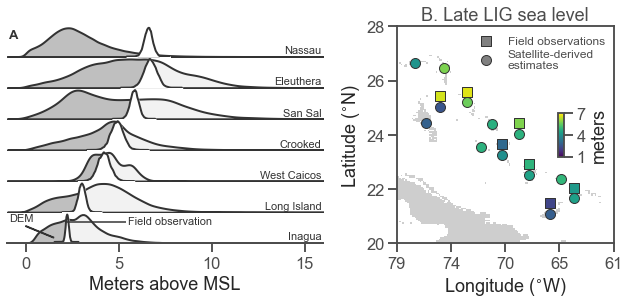

In [32]:
fig = plt.figure(figsize=(9.5, 13 / 3))
gs = gridspec.GridSpec(7, 2)

sns.set_style(
    "ticks",
    {
        "axes.edgecolor": ".3",
        "xtick.color": ".3",
        "ytick.color": ".3",
        "text.color": ".3",
        "axes.facecolor": "(1,1,1)",
        "axes.grid": False,
        "grid.color": ".9",
        "grid.linestyle": u"-.",
        "font.family": ["sans-serif"],
    },
)


k = [0, 1, 2, 4, 6, 3, 5]  # plot order

for plotN, i in enumerate(k):

    ax1 = fig.add_subplot(gs[plotN, 0])

    ax2 = ax1.twinx()

    elev_of_field = field_sites["Elevation"].values[i]
    unc_of_field = field_sites["Uncertainty (2 sigma)"].values[i]
    name_of_island = field_sites["Island"].values[i]
    matching_id = map_of_ids[name_of_island]
    mapped_mask_id = source_layer[matching_id].GetField("id")

    arr_to_plot = raster_ele[(raster_masks == mapped_mask_id) & (map_arr == 2)].ravel()
    arr_to_plot = arr_to_plot[arr_to_plot > 0]
    arr_kde = gaussian_kde(arr_to_plot)

    d_x = np.linspace(-1, elev_of_field, 200)
    ax1.fill_between(
        d_x,
        np.zeros(d_x.size),
        arr_kde(d_x),
        facecolor=(0.75, 0.75, 0.75),
        edgecolor=(0.2, 0.2, 0.2),
        lw=2,
    )

    d_x = np.linspace(elev_of_field, 20, 200)
    ax1.fill_between(
        d_x,
        np.zeros(d_x.size),
        arr_kde(d_x),
        facecolor=(0.95, 0.95, 0.95),
        edgecolor=(0.2, 0.2, 0.2),
        lw=2,
    )

    sns.kdeplot(
        np.random.normal(elev_of_field, unc_of_field, 10000),
        clip=[-2, 20],
        gridsize=1000,
        bw=0.1,
        shade=True,
        lw=2,
        color=(0.2, 0.2, 0.2),
        alpha=1,
        facecolor="white",
        ax=ax2,
    )

    ax2.text(
        15.9,
        ax2.get_ylim()[1] * 0.1,
        name_of_island,
        horizontalalignment="right",
        fontsize=11,
        color=(0.2, 0.2, 0.2),
    )

    plt.gca().set_xlim([-1, 16])
    ax1.set_yticklabels([])
    ax2.set_yticklabels([])
    ax1.set_yticks([])
    ax1.set_ylim([0, np.max(arr_kde(np.linspace(0, 20, 100)) * 1.05)])
    ax2.set_yticks([])
    ax1.spines["left"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax2.spines["right"].set_visible(False)

    if plotN == 0:
        ax2.text(
            -0.9,
            ax2.get_ylim()[1] * 0.9,
            "A",
            horizontalalignment="left",
            verticalalignment="top",
            fontsize=13,
            color=(0.2, 0.2, 0.2),
            weight="bold",
        )

    if plotN < len(field_sites) - 1:
        plt.gca().set_xticklabels([])
        plt.gca().set_xticks([])
        ax1.spines["bottom"].set_visible(False)
        ax2.spines["bottom"].set_visible(False)
    else:
        ax2.text(
            5.5,
            ax2.get_ylim()[1] * 0.6,
            "Field observation",
            horizontalalignment="left",
            fontsize=11,
            color=(0.2, 0.2, 0.2),
            zorder=5,
        )
        ax2.arrow(
            5.4,
            ax2.get_ylim()[1] * 0.7,
            2.23 - 5.4,
            0,
            width=0.05,
            head_width=0.02,
            head_length=0,
            length_includes_head=True,
            overhang=0.4,
            zorder=5,
            color=(0.2, 0.2, 0.2),
        )
        ax2.text(
            -0.9,
            ax2.get_ylim()[1] * 1,
            "DEM",
            horizontalalignment="left",
            verticalalignment="top",
            fontsize=11,
            color=(0.2, 0.2, 0.2),
            zorder=5,
        )
        ax2.arrow(
            0,
            ax2.get_ylim()[1] * 0.55,
            1.5,
            ax2.get_ylim()[1] * -0.4,
            width=0.05,
            head_width=0.02,
            head_length=0,
            length_includes_head=True,
            overhang=0.4,
            zorder=5,
            color=(0.2, 0.2, 0.2),
        )
        ax2.set_xticks([0, 5, 10, 15])
        ax2.set_xticklabels(
            np.array([0, 5, 10, 15]).astype(str), fontsize=15, color=(0.2, 0.2, 0.2)
        )
        ax1.set_xlabel("Meters above MSL")

ax7 = fig.add_subplot(gs[:, 1])

source_ds = ogr.Open(str(data_dir) + "/processed/" + vector_layer)
source_layer = source_ds.GetLayer()

my_grey = plt.cm.Greys_r
my_grey.set_under("k", alpha=0)
plt.imshow(
    imarray,
    interpolation="nearest",
    cmap=my_grey,
    vmin=0.3,
    vmax=1.3,
    extent=imarray_ext,
)

x_es = []
y_es = []
for i in range(len(source_layer)):
    if i == 11:
        continue  # skips second caicos

    y = source_layer[i].GetField("Y_Mean")
    y_es.append(y)
    x = source_layer[i].GetField("X_Mean")
    x_es.append(x)
    id_num = source_layer[i].GetField("id")
    masked = raster_ele[(raster_masks == (id_num)) & (map_arr == 2)]
    c = np.percentile(masked[masked > -10], proxy_percentile)
    plt.scatter(
        [x],
        [y],
        c=[c],
        cmap="viridis",
        vmin=1,
        vmax=7,
        s=100,
        linewidths=1,
        edgecolors=(0.2, 0.2, 0.2),
    )


plt.scatter(
    [],
    [],
    marker="s",
    c=(0.5, 0.5, 0.5),
    s=100,
    linewidths=1,
    edgecolors=(0.2, 0.2, 0.2),
    label="Field observations",
)
plt.scatter(
    [],
    [],
    marker="o",
    c=(0.5, 0.5, 0.5),
    s=100,
    linewidths=1,
    edgecolors=(0.2, 0.2, 0.2),
    label="Satellite-derived\nestimates",
)
plt.legend(
    loc="upper right", labelspacing=0.25, borderpad=0.25, fontsize=12, frameon=False
)

for i in range(field_island_data.shape[0]):

    y = np.array(y_es)[np.argmin(np.abs(np.array(y_es) - field_island_data[i, 2]))]
    x = np.array(x_es)[
        np.argmin(np.abs(np.array(x_es) - 0.1 - field_island_data[i, 3]))
    ]
    c = field_island_data[i, 1]
    plt.scatter(
        [x],
        [y + 0.4],
        c=[c],
        cmap="viridis",
        vmin=1,
        vmax=7,
        s=100,
        marker="s",
        linewidths=1,
        edgecolors=(0.2, 0.2, 0.2),
    )

plt.gca().set_title("B. Late LIG sea level")
plt.gca().grid(False)
plt.gca().set_yticks([])
plt.gca().set_ylim([20, 28])
plt.gca().set_xlim([-79, -71])
plt.gca().set_ylabel("Latitude ($^{\circ}$N)")
plt.gca().set_xticks(np.linspace(-79, -71, 5).astype(int))
plt.gca().set_xticklabels(-1 * np.linspace(-79, -61, 5).astype(int))
plt.gca().set_yticks(np.linspace(20, 28, 5).astype(int))
plt.gca().set_yticklabels(np.linspace(20, 28, 5).astype(int))
plt.gca().set_xlabel("Longitude ($^{\circ}$W)")


cbaxis = inset_axes(plt.gca(), width="3%", height="20%", loc=5, borderpad=3)
plt.colorbar(cax=cbaxis, orientation="vertical", label="meters", ticks=[1, 4, 7])

fig.tight_layout(h_pad=0.1, w_pad=-3)
fig.savefig("Figure_S1.pdf", bbox_inches="tight", dpi=300)